/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 7.81831482e-01  6.23489802e-01  9.74927912e-01 ... -9.00968868e-01
  -4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01 -4.33883739e-01 ...  6.23489802e-01
   7.81831482e-01  6.23489802e-01]
 ...
 [-9.74927912e-01 -2.22520934e-01  4.33883739e-01 ...  6.23489802e-01
  -7.81831482e-01  6.23489802e-01]
 [-7.81831482e-01  6.23489802e-01 -9.74927912e-01 ... -9.00968868e-01
   4.33883739e-01 -9.00968868e-01]
 [-4.11580361e-14  1.00000000e+00 -8.23160723e-14 ...  1.00000000e+00
  -1.64632145e-13  1.00000000e+00]]


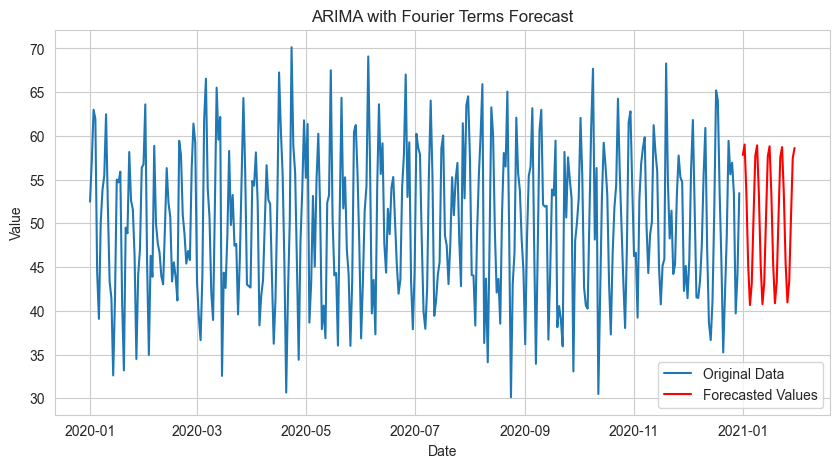

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
# Generate synthetic time series data with daily seasonality
np.random.seed(42)
n = 365  # Number of data points
t = np.arange(n)
seasonality = 7  # Weekly seasonality
data = 50 + 10 * np.sin(2 * np.pi * t / seasonality) + np.random.normal(0, 5, n)

# Convert the data to a pandas DataFrame
df = pd.DataFrame({'Date': pd.date_range(start='2020-01-01', periods=n), 'Value': data})
df.set_index('Date', inplace=True)

# Create Fourier terms for weekly seasonality
def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * t / period))
        terms.append(np.cos(2 * np.pi * i * t / period))
    return np.column_stack(terms)

num_fourier_terms = 4
fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

print(fourier_terms)

# Fit the ARIMA model using pmdarima's auto_arima with Fourier terms as exogenous variables
model = auto_arima(df['Value'],exogenous=fourier_terms[:n], seasonal=True, suppress_warnings=True)
model.fit(df['Value'], exogenous=fourier_terms[:n])

# Forecast future values with the fitted model
forecast_steps =30
forecast_exog = create_fourier_terms(np.arange(n, n + forecast_steps), seasonality, num_fourier_terms)

# Get the forecast for the future steps with exogenous variables
forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])
#forecast_values = model.predict(n_periods=forecast_steps)
forecast_values = model.predict(n_periods=forecast_steps, exogenous=forecast_df)

# Retrieve the index for forecasting
forecast_index = pd.date_range(start='2021-01-01', periods=forecast_steps)

# Plot the original data and the forecasted values
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Value'], label='Original Data')
plt.plot(forecast_index, forecast_values, label='Forecasted Values', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA with Fourier Terms Forecast')
plt.legend()
plt.show()

# Seasonal-Trend decomposition using LOESS (STL)

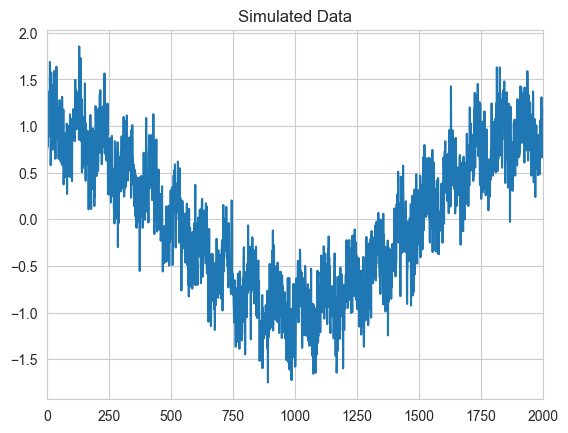

In [2]:
import numpy as np

rs = np.random.RandomState(0xA4FD94BC)
tau = 2000
t = np.arange(tau)
period = int(0.05 * tau)
seasonal = period + ((period % 2) == 0)  # Ensure odd
e = 0.25 * rs.standard_normal(tau)
y = np.cos(t / tau * 2 * np.pi) + 0.25 * np.sin(t / period * 2 * np.pi) + e
plt.plot(y)
plt.title("Simulated Data")
xlim = plt.gca().set_xlim(0, tau)

79.6 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


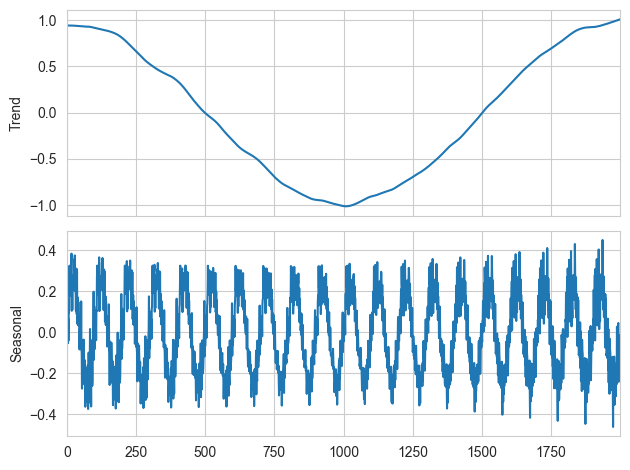

In [3]:

from statsmodels.tsa.stl._stl import STL

mod = STL(y, period=period, seasonal=seasonal)
%timeit mod.fit()
res = mod.fit()
fig = res.plot(observed=False, resid=False)

In [4]:
res

# Multiple Seasonal-Trend decomposition using LOESS (MSTL)

In [5]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

register_matplotlib_converters()
sns.set_style("darkgrid")

In [6]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [7]:
t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
trend = 0.0001 * t**2
y = trend + daily_seasonality + weekly_seasonality + np.random.randn(len(t))
ts = pd.date_range(start="2020-01-01", freq="H", periods=len(t))
df = pd.DataFrame(data=y, index=ts, columns=["y"])

In [8]:
df.head()


,y
2020-01-01 00:00:00,1.266887
2020-01-01 01:00:00,3.471793
2020-01-01 02:00:00,4.668671
2020-01-01 03:00:00,5.919826
2020-01-01 04:00:00,5.918235


<Axes: >

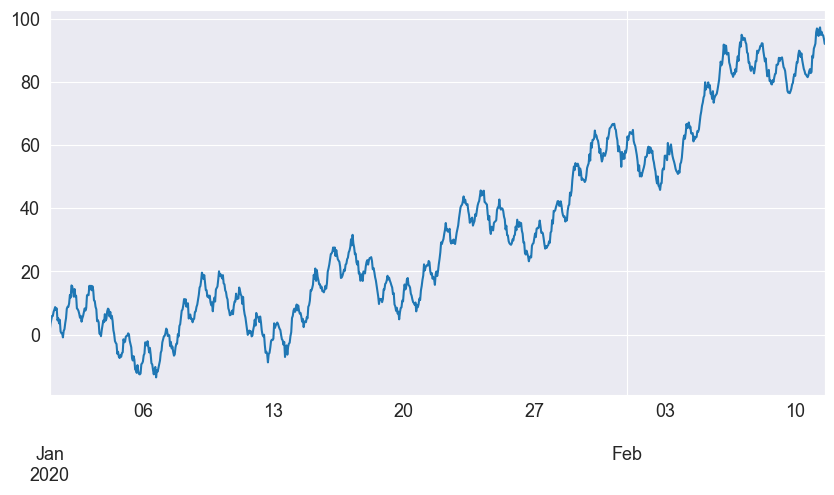

In [9]:
df["y"].plot(figsize=[10, 5])


In [10]:

mstl = MSTL(df["y"], periods=[24, 24 * 7])
res = mstl.fit()

In [11]:
res.seasonal.head()


,seasonal_24,seasonal_168
2020-01-01 00:00:00,1.000390,1.123100
2020-01-01 01:00:00,2.046695,1.575569
2020-01-01 02:00:00,3.493247,1.370960
2020-01-01 03:00:00,4.529483,1.481135
2020-01-01 04:00:00,4.775096,1.736522


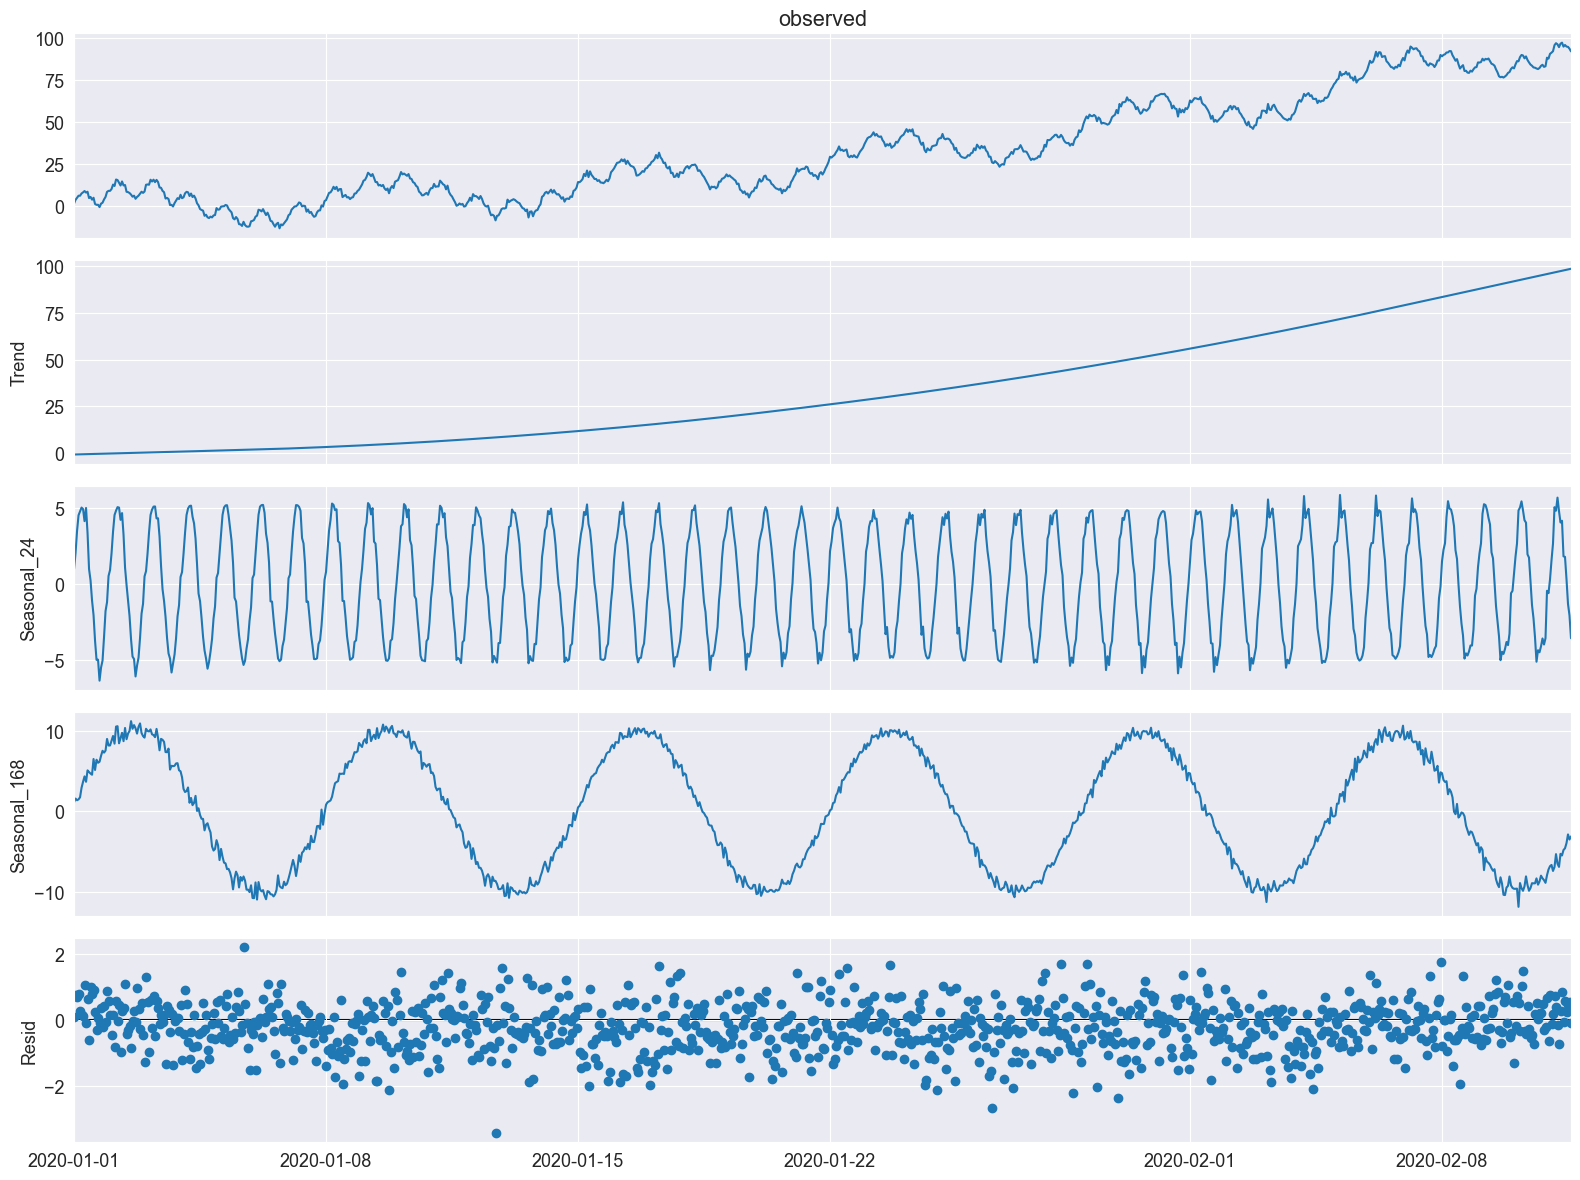

In [12]:
ax = res.plot()


# MSTL Using Energy data (Australia)

In [13]:
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

In [14]:

df.head()

,Date,Period,OperationalLessIndustrial,Industrial
0,37257,1,3535.867064,1086.132936
1,37257,2,3383.499028,1088.500972
2,37257,3,3655.527552,1084.472448
3,37257,4,3510.446636,1085.553364
4,37257,5,3294.697156,1081.302844


In [15]:
df["Date"] = df["Date"].apply(lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days"))
df["ds"] = df["Date"] + pd.to_timedelta((df["Period"]-1)*30, unit="m")


In [16]:
timeseries = df[["ds", "OperationalLessIndustrial"]]
timeseries.columns = ["ds", "y"] # Rename to OperationalLessIndustrial to y for simplicity.

# Filter for first 149 days of 2012.
start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")
mask = (timeseries["ds"] >= start_date) & (timeseries["ds"] < end_date)
timeseries = timeseries[mask]

# Resample to hourly
timeseries = timeseries.set_index("ds").resample("H").sum()
timeseries.head()


,y
ds,
2012-01-01 00:00:00,7926.529376
2012-01-01 01:00:00,7901.826990
2012-01-01 02:00:00,7255.721350
2012-01-01 03:00:00,6792.503352
2012-01-01 04:00:00,6635.984460


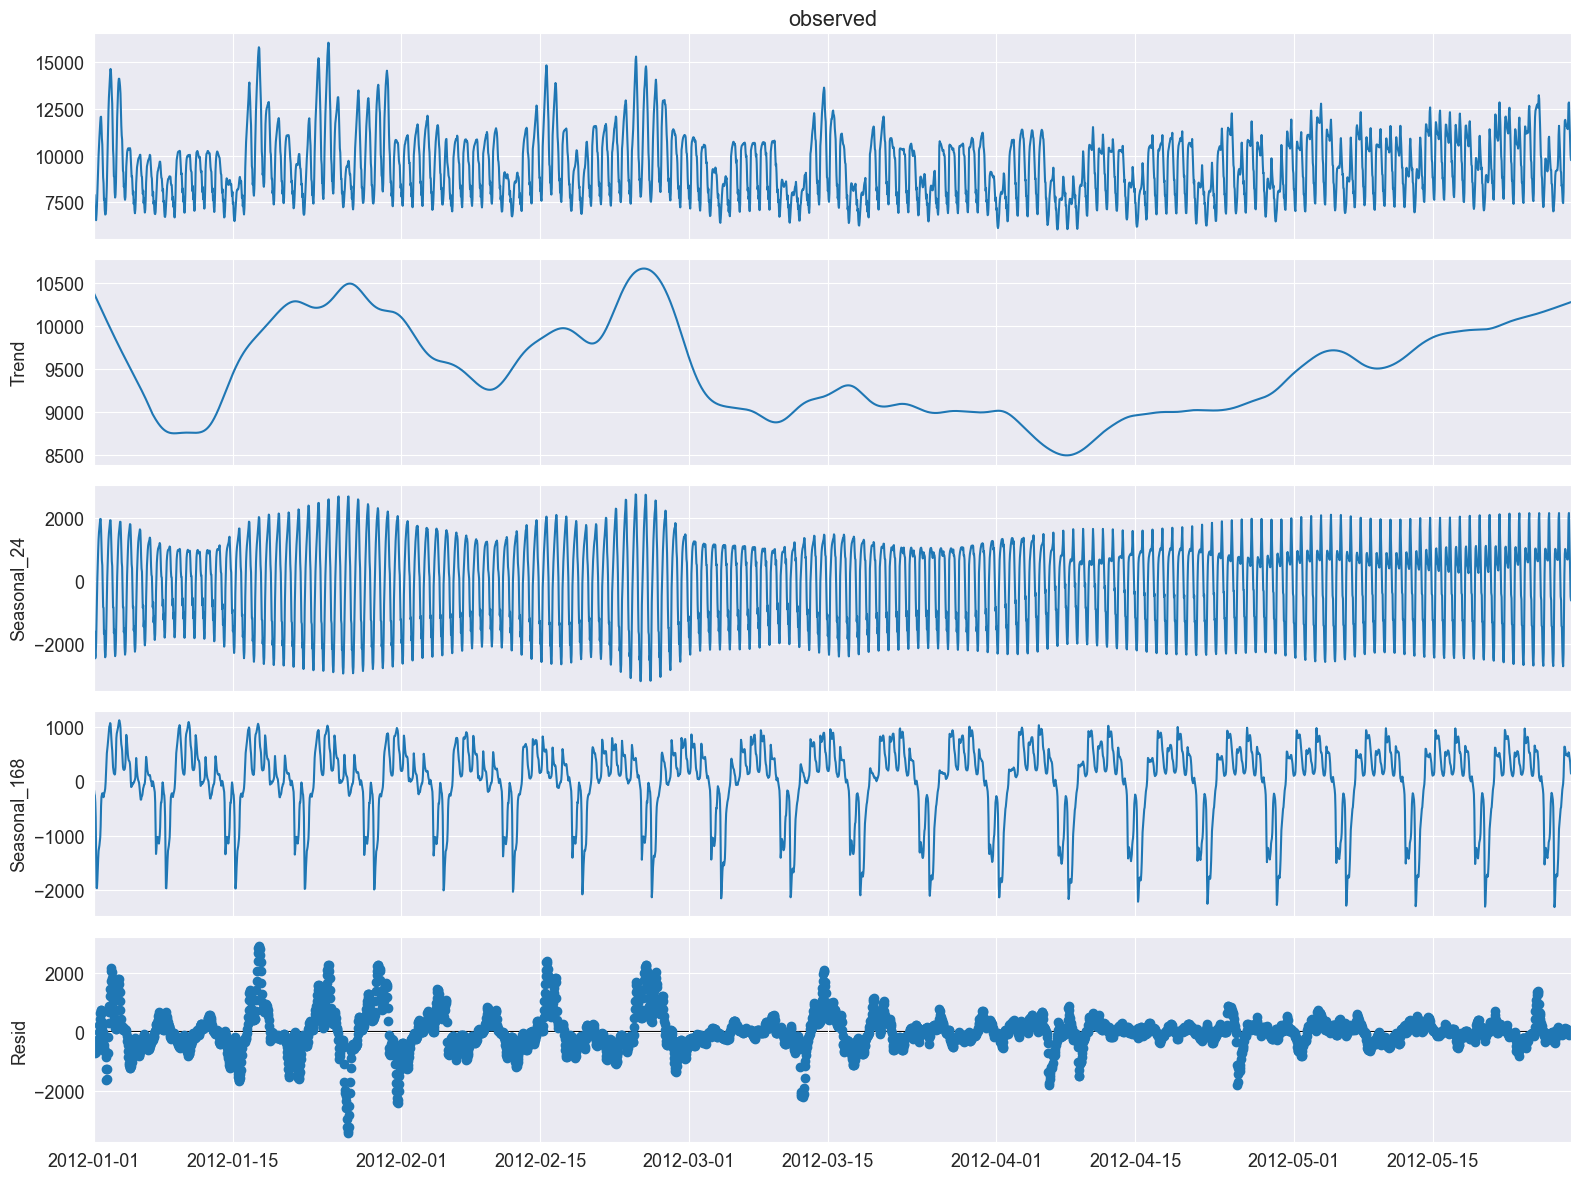

In [17]:
mstl = MSTL(timeseries["y"], periods=[24, 24 * 7], iterate=3, stl_kwargs={"seasonal_deg": 0,
                                                                          "inner_iter": 2,
                                                                          "outer_iter": 0})
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()


In [18]:
res.seasonal

,seasonal_24,seasonal_168
ds,,
2012-01-01 00:00:00,-1685.986297,-161.807086
2012-01-01 01:00:00,-1591.640845,-229.788887
2012-01-01 02:00:00,-2192.989492,-260.121300
2012-01-01 03:00:00,-2442.169359,-388.484499
2012-01-01 04:00:00,-2357.492551,-660.245476
...,...,...
2012-05-28 19:00:00,1534.555019,474.111504
2012-05-28 20:00:00,975.199465,411.048278
2012-05-28 21:00:00,240.882025,355.233651


# Doing the same for out energy data

In [21]:
from Energy.HelpFunctions.get_energy_data import fetch_energy_data

# fetch_energy_data()

  0%|          | 0/263 [00:00<?, ?it/s]/Users/elias/Desktop/PTSFC/Energy/HelpFunctions/get_energy_data.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 263/263 [00:26<00:00,  9.75it/s]


In [22]:
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import MSTL

df = get_energy_data()
df = prepare_data(df)

start_date = pd.to_datetime("2020-01-01")
end_date = pd.to_datetime("2023-12-31")

mask = (df.index >= start_date) & (df.index < end_date)
df = df[mask]

In [23]:
df

,gesamt
date_time,
2020-01-01 00:00:00,43.49400
2020-01-01 01:00:00,42.61250
2020-01-01 02:00:00,41.48800
2020-01-01 03:00:00,40.30175
2020-01-01 04:00:00,40.29675
...,...
2023-12-30 19:00:00,50.22900
2023-12-30 20:00:00,47.60575
2023-12-30 21:00:00,45.04200


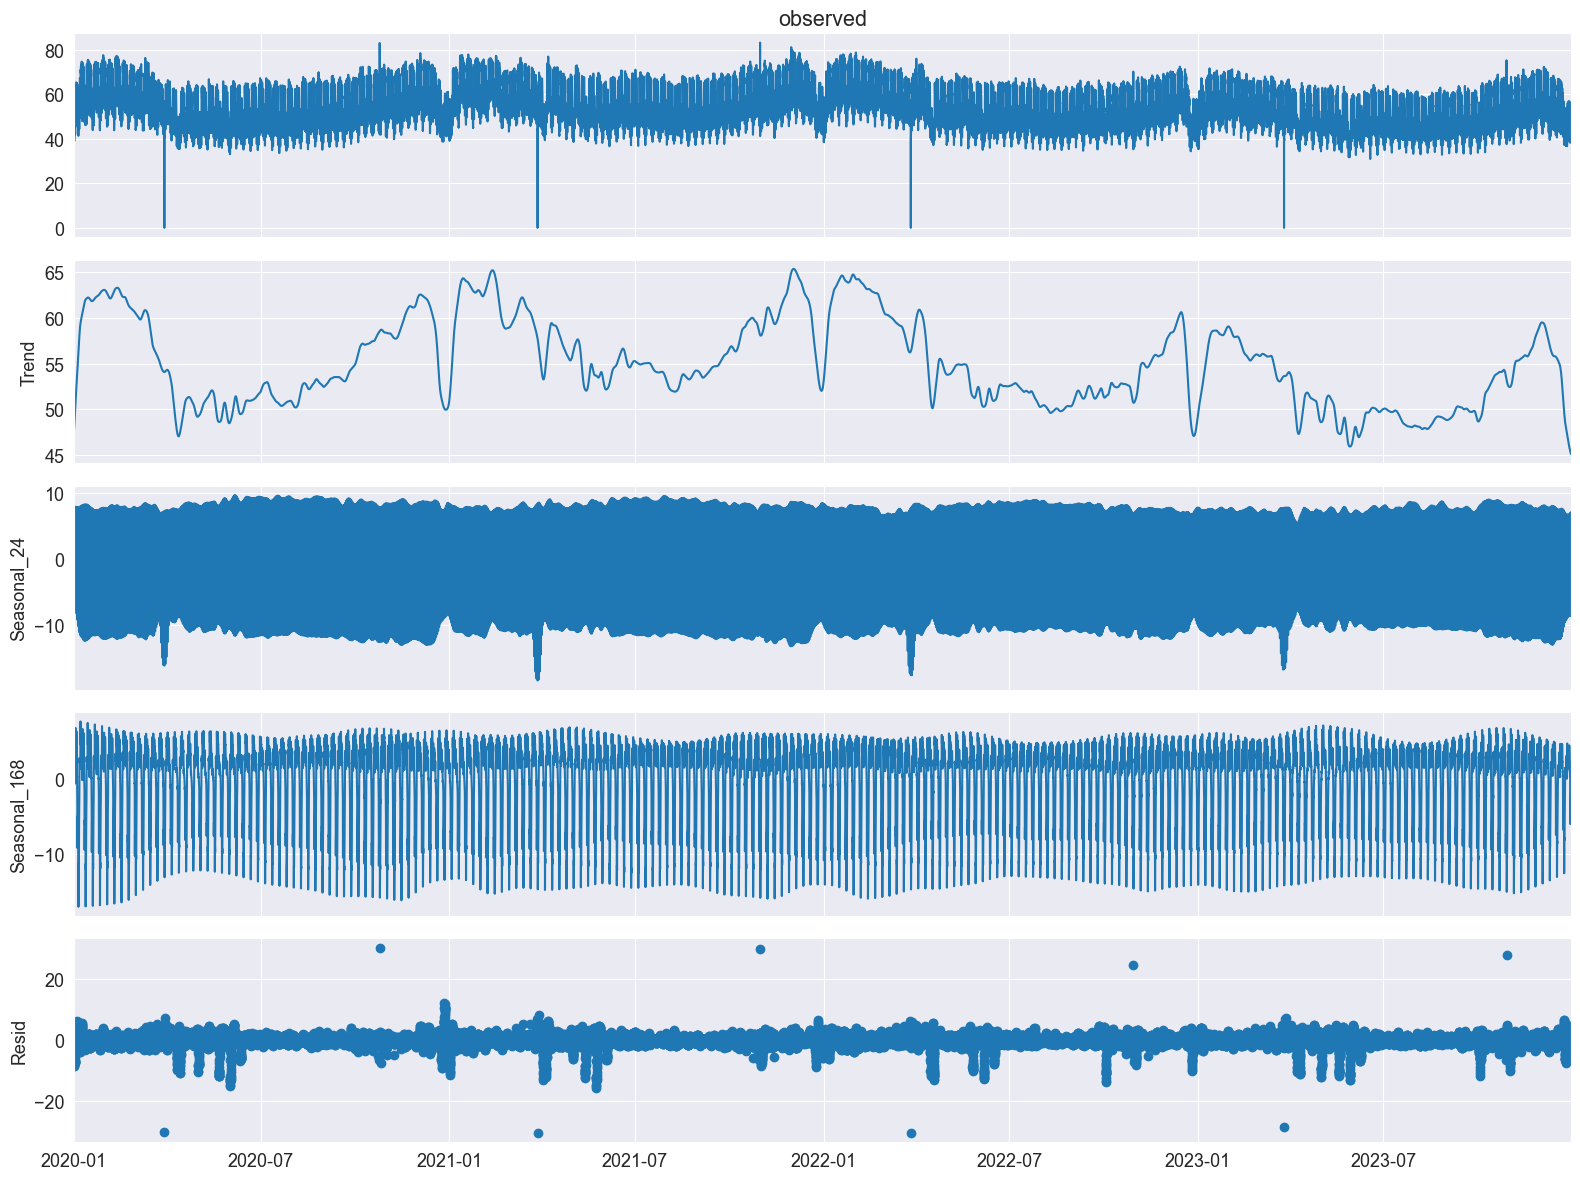

In [24]:
mstl = MSTL(df['gesamt'], periods=[24, 24 * 7], iterate=3)
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()
plt.savefig(f'../plots/MSLT.png')
plt.show()

In [25]:
object_methods = [f'{method_name}: {callable(getattr(res, method_name))}' for method_name in dir(res)]

In [26]:
object_methods

['__class__: True',
 '__delattr__: True',
 '__dict__: False',
 '__dir__: True',
 '__doc__: False',
 '__eq__: True',
 '__format__: True',
 '__ge__: True',
 '__getattribute__: True',
 '__gt__: True',
 '__hash__: True',
 '__init__: True',
 '__init_subclass__: True',
 '__le__: True',
 '__lt__: True',
 '__module__: False',
 '__ne__: True',
 '__new__: True',
 '__reduce__: True',
 '__reduce_ex__: True',
 '__repr__: True',
 '__setattr__: True',
 '__sizeof__: True',
 '__str__: True',
 '__subclasshook__: True',
 '__weakref__: False',
 '_observed: False',
 '_resid: False',
 '_seasonal: False',
 '_trend: False',
 '_weights: False',
 'nobs: False',
 'observed: False',
 'plot: True',
 'resid: False',
 'seasonal: False',
 'trend: False',
 'weights: False']

In [27]:
res.trend

date_time
2020-01-01 00:00:00    47.745643
2020-01-01 01:00:00    47.836325
2020-01-01 02:00:00    47.926810
2020-01-01 03:00:00    48.017095
2020-01-01 04:00:00    48.107179
                         ...    
2023-12-30 19:00:00    45.199503
2023-12-30 20:00:00    45.182641
2023-12-30 21:00:00    45.165936
2023-12-30 22:00:00    45.149385
2023-12-30 23:00:00    45.132986
Freq: H, Name: trend, Length: 35040, dtype: float64

In [28]:
mstl.forecast()

AttributeError: 'MSTL' object has no attribute 'forecast'

In [ ]:
from statistics import mean

mean(res.resid)

In [ ]:
plt.plot(res.trend[-5000:])

In [ ]:
d = pd.DataFrame(res.seasonal.seasonal_24[-500:] + res.seasonal.seasonal_168[-500:] + res.trend[-500:])
d.columns = ['24p168_trend']
d['weekly'] = res.seasonal.seasonal_168[-500:]
d['trend'] = res.trend
d['obs'] = df
plt.plot(d)

In [ ]:
d

In [ ]:
# plt.plot(res.resid)

sns.kdeplot(res.resid)

# Forecast using STL

In [29]:
from sktime.datasets import load_airline
from sktime.forecasting.statsforecast import StatsForecastMSTL

In [47]:
import pandas as pd
start_date = pd.to_datetime("2021-01-01")
end_date = pd.to_datetime("2023-12-07")

mask = (df.index >= start_date) & (df.index < end_date)
y = df[mask]
model = StatsForecastMSTL(season_length=[24,24*7, 24*364]) 
fitted_model = model.fit(y=y) 


In [68]:
y_pred = fitted_model.predict(fh=[i for i in range(1,73)]) 

In [69]:
start_date = pd.to_datetime("2023-12-07")
end_date = pd.to_datetime("2023-12-10")

mask = (df.index >= start_date) & (df.index < end_date)
obs = df[mask]

(19696.0, 19703.0)

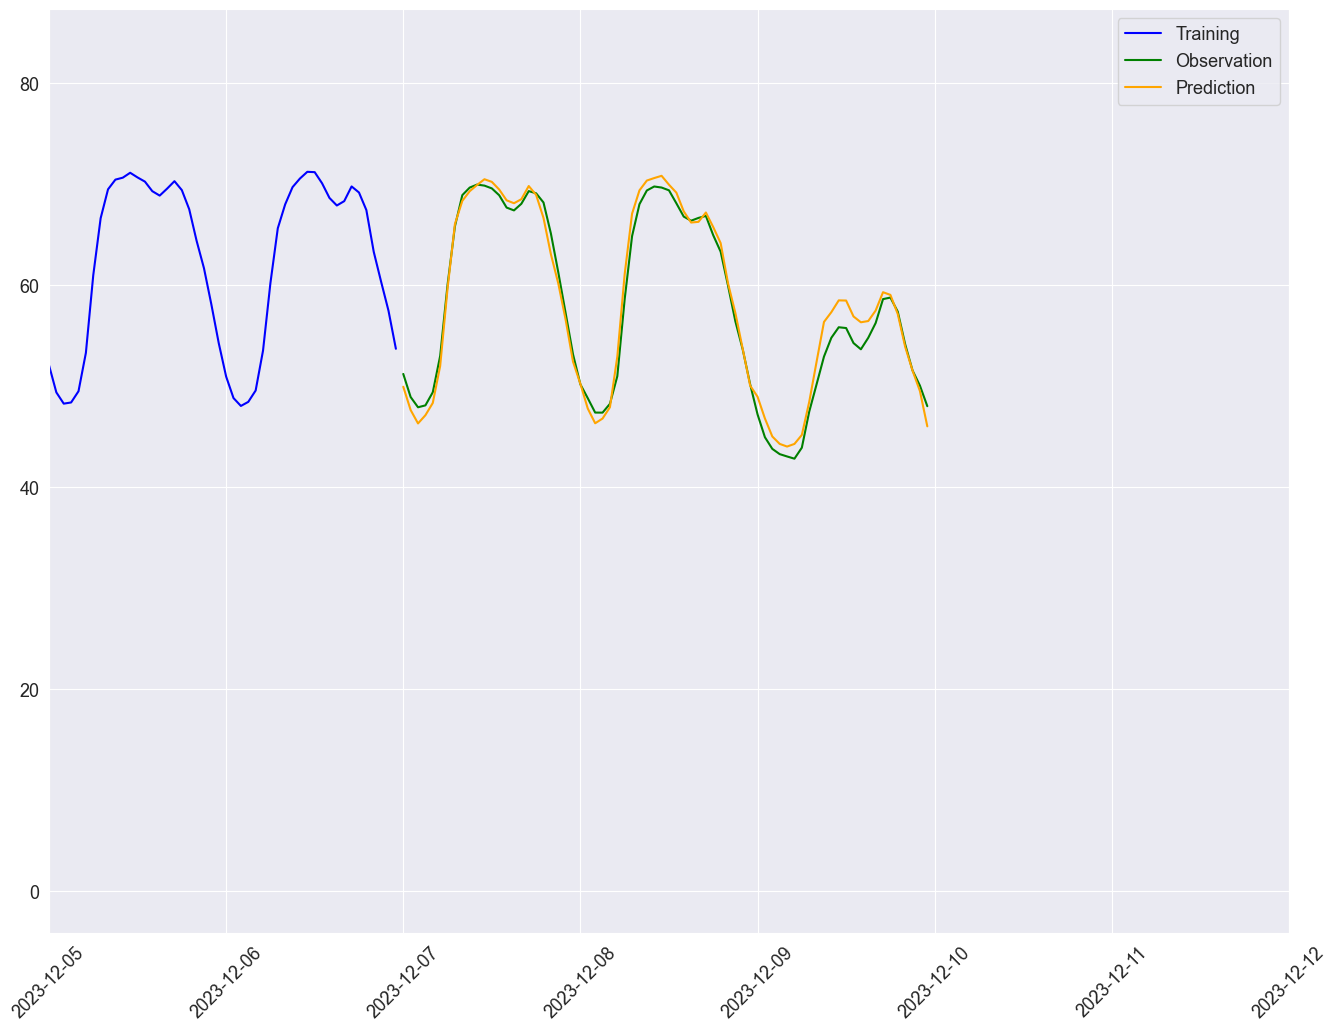

In [70]:
import matplotlib.pyplot as plt
# y.index = y.index.to_timestamp()
plt.plot(y, color='blue', label='Training')

plt.plot(obs, color='green', label='Observation')
plt.plot(y_pred, color='orange', label='Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime("2023-12-05"),pd.to_datetime("2023-12-12"))

In [57]:
y_pred2 = fitted_model.predict_quantiles(fh=[i for i in range(1,90)]) 

AttributeError: 'StatsForecastBackAdapter' object has no attribute '_add_predict_conformal_intervals'

In [68]:
print(y_pred.loc["2023-12-08"])

KeyError: '2023-12-08'

In [69]:
print(obs.loc["2023-12-08"])

KeyError: '2023-12-08'

In [14]:
model.predict_residuals(fh=[i for i in range(1,500)])

TypeError: predict_residuals() got an unexpected keyword argument 'fh'

In [15]:
model.residuals_

AttributeError: 'StatsForecastMSTL' object has no attribute 'residuals_'

In [16]:
object_methods = [method_name for method_name in dir(model)]

In [17]:
object_methods

['_X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rpow__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_alias_params',
 '_check_X',
 '_check_X_y',
 '_check_fh',
 '_check_supports_pred_int',
 '_clone',
 '_clone_flags',
 '_components',
 '_config',
 '_config_doc',
 '_config_dynamic',
 '_converter_store_y',
 '_cutoff',
 '_fh',
 '_fit',
 '_forecaster',
 '_get_class_flag',
 '_get_class_flags',
 '_get_fitted_params',
 '_get_fitted_params_default',
 '_get_flag',
 '_get_flags',
 '_get_init_signature',
 '_get_init_statsforecast_params',
 '_get_set_config_doc',
 '_get_statsforecast_class',
 '_get_statsforecast_default_params',
 '_get_statsforecast_params',
 '_ge

In [30]:
model.predict_residuals(y)

,gesamt
date_time,
2023-01-01 00:00:00,2.085022
2023-01-01 01:00:00,2.998927
2023-01-01 02:00:00,2.566563
2023-01-01 03:00:00,2.829221
2023-01-01 04:00:00,2.646149
...,...
2023-12-30 19:00:00,0.926318
2023-12-30 20:00:00,1.190412
2023-12-30 21:00:00,0.841093


<Axes: ylabel='Density'>

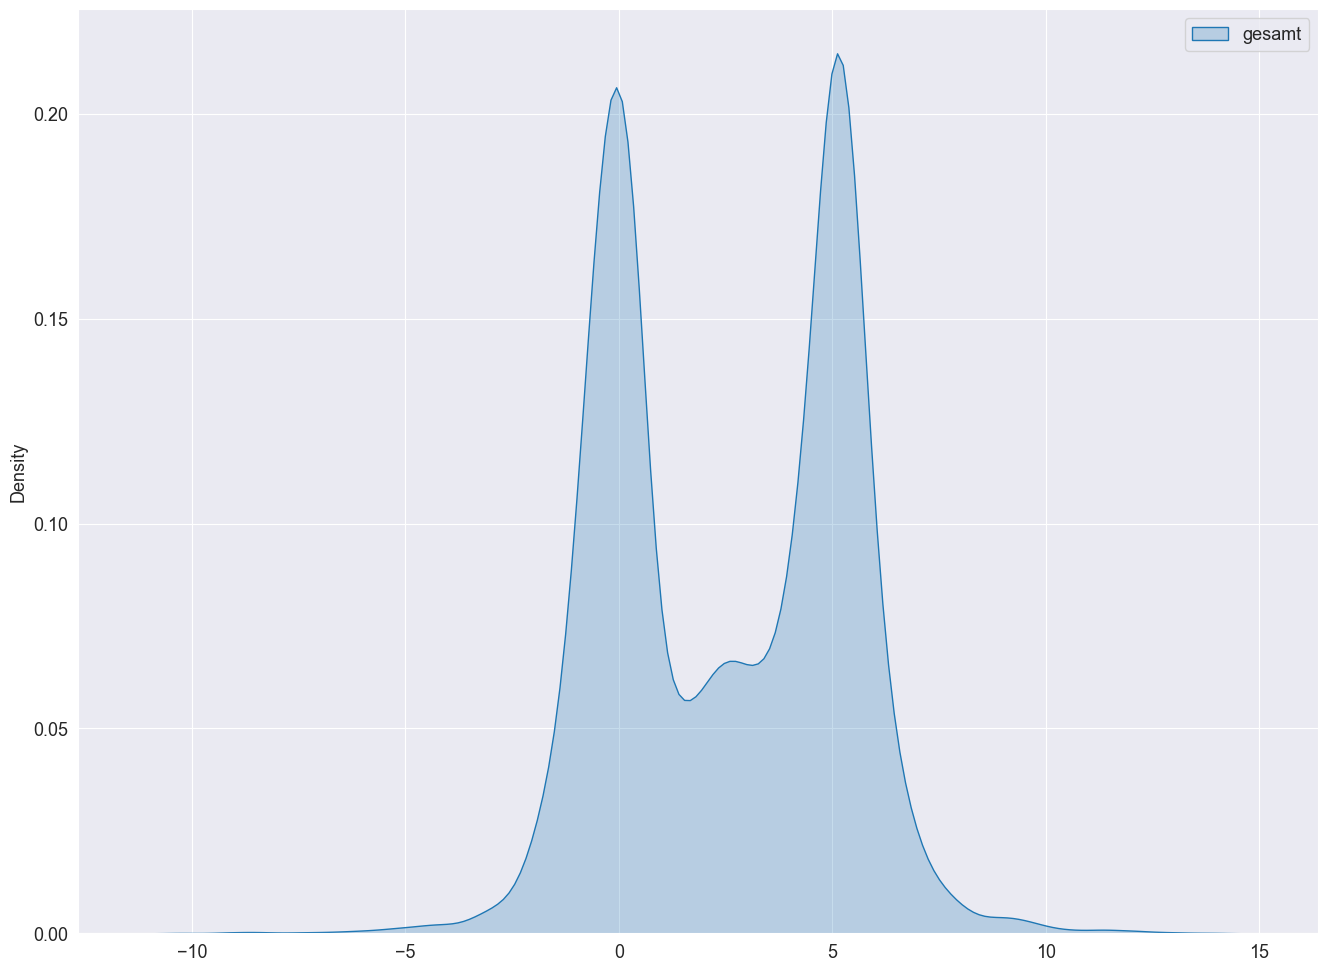

In [58]:
import seaborn as sns
sns.kdeplot(data=model.predict_residuals(y), fill=True)

In [71]:
from statistics import mean, median
mean(model.predict_residuals(y)['gesamt'])

-3.986227352591262

In [41]:
residuals = model.predict_residuals(y)

In [43]:
from scipy.stats import norm

mean, std_dev = norm.fit(residuals)

In [45]:
import numpy as np
quantiles = np.quantile(residuals, [.025, .25, .5, .75, .975])

In [46]:
quantiles

array([-0.07400568,  4.71574735,  7.89108483, 12.24915627, 18.07241629])

Calculate residuals manually

<Axes: ylabel='Density'>

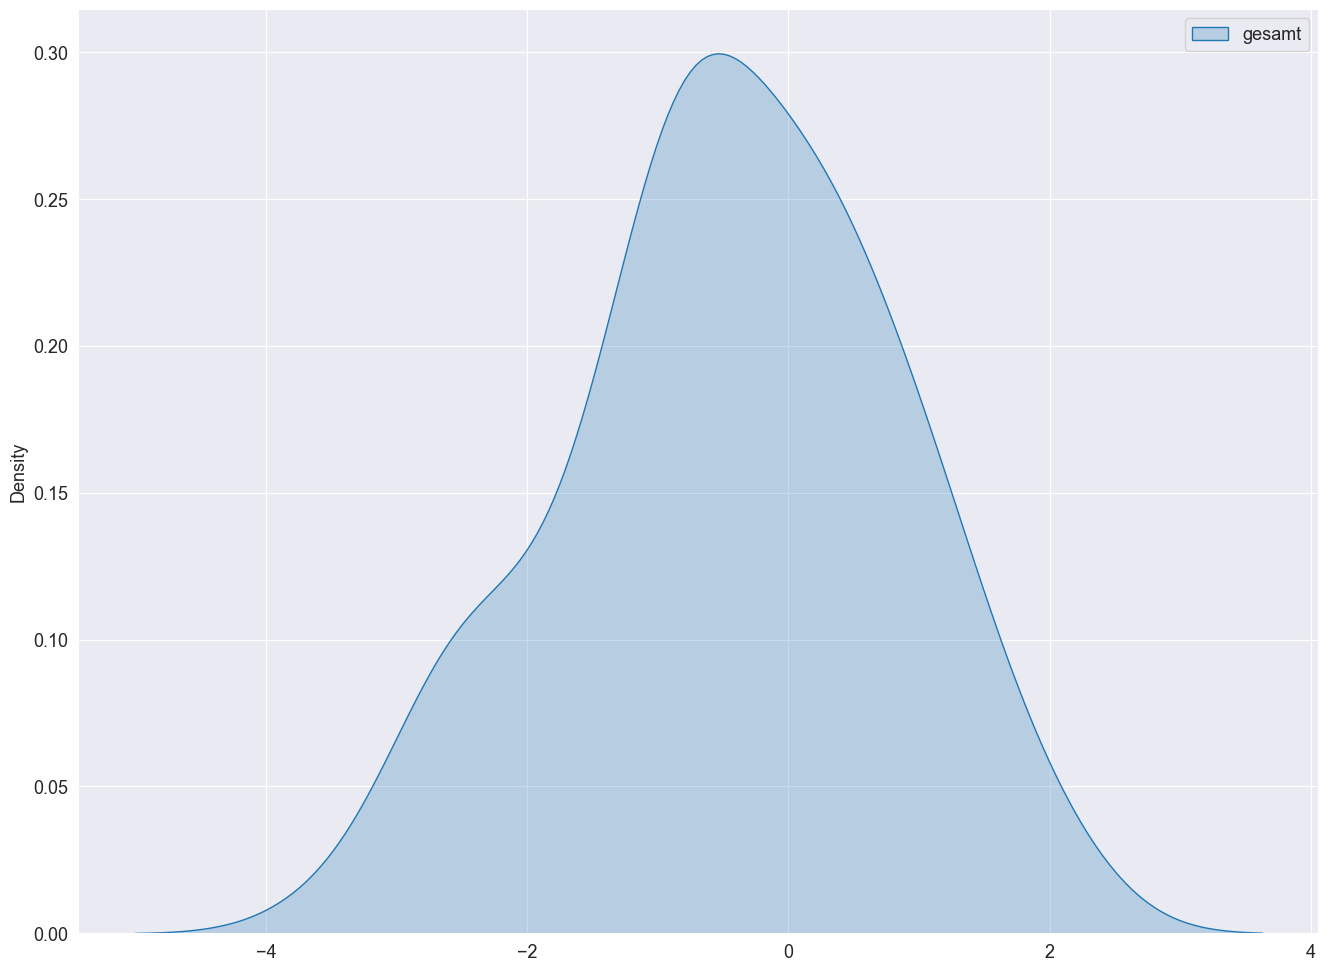

In [73]:
residuals = obs - y_pred
sns.kdeplot(residuals, fill=True)

They look much better than the "predicted" residuals. Lets use them instead.

In [72]:
residuals

,gesamt
date_time,
2023-12-07 00:00:00,1.264373
2023-12-07 01:00:00,1.285909
2023-12-07 02:00:00,1.598484
2023-12-07 03:00:00,0.975201
2023-12-07 04:00:00,1.061551
...,...
2023-12-09 19:00:00,0.237066
2023-12-09 20:00:00,0.250378
2023-12-09 21:00:00,0.016576
